In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

import wandb
wandb.init()
#from Model.network import Net

wandb: Currently logged in as: kingconcentrer (kingconcentrer-1) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 80, kernel_size = 5).cuda()
        self.conv2 = nn.Conv2d(80, 80, kernel_size = 5).cuda()

        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0).cuda()
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0).cuda()

        self.batch_norm1 = nn.BatchNorm2d(80).cuda()
        self.batch_norm2 = nn.BatchNorm2d(80).cuda()

        self.fc1 = nn.Linear(1280, 250).cuda()
        self.fc2 = nn.Linear(250, 25).cuda()

    def forward(self, x):

        x = self.conv1(x).cuda()
        x = self.batch_norm1(x).cuda()
        x = F.relu(x).cuda()
        x = self.pool1(x).cuda()

        x = self.conv2(x).cuda()
        x = self.batch_norm2(x).cuda()
        x = F.relu(x).cuda()
        x = self.pool2(x).cuda()

        x = x.view(x.size(0), -1).cuda()

        x = F.relu(self.fc1(x)).cuda()
        x = self.fc2(x).cuda()
        x = F.log_softmax(x, dim=1).cuda()

        return x

In [ ]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

train_data = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_train.csv")
test_data = pd.read_csv(r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/Data/sign_mnist_test.csv")
#print(train_data.head(10))
#print(train_data.describe())
#print(train_data.info())


cuda
NVIDIA GeForce RTX 3060 Laptop GPU 



In [4]:
class SignsLanguageDataset(Dataset):

    def __init__(self, train=True, transform=None):

        self.train = train
        self.transform = transform

        if self.train == True:
            self.signs_lang_dataset = train_data
        else:
            self.signs_lang_dataset = test_data

        self.X_set = self.signs_lang_dataset.iloc[:, 1:].values
        self.y_set = self.signs_lang_dataset.iloc[:, 0].values

        self.X_set = np.reshape(self.X_set, (self.X_set.shape[0], 1, 28, 28)) / 255
        self.y_set = np.array(self.y_set)

    def __getitem__(self, index):

        image = self.X_set[index, :, :]

        label = self.y_set[index]

        sample = {'image_sign': image, 'label': label}

        return sample

    def __len__(self):
        return self.X_set.__len__()


def train(model, optimizer, epoch, device, train_loader, log_interval):
 
    model.train()
    for batch_idx, data in enumerate(train_loader):

        img = data['image_sign']
        img = img.type(torch.FloatTensor).to(device)
        target = data['label']
        target = target.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        output = model(img).cuda()
        loss = F.nll_loss(output, target)

        loss.backward()
        optimizer.step()
        wandb.log({ "train loss": loss})
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
        

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            img = data['image_sign']
            img = img.type(torch.FloatTensor).to(device)
            target = data['label']
            target = target.type(torch.LongTensor).to(device)

            output = model(img)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_acc = 100. * correct / len(test_loader.dataset)
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    wandb.log({"test loss": test_loss, "test accuracy" : test_acc })



In [ ]:


device = 'cpu'
batch_size_train = 5
batch_size_test = 4

dataset_train = SignsLanguageDataset(train = True)
dataset_test = SignsLanguageDataset(train = False)
train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size_train)
test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size_test)

torch.manual_seed(123)

learning_rate = 0.001
num_epochs = 15
model = Net()

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.2, weight_decay = 0.002)
log_interval = 27455

for epoch in range(1, num_epochs + 1):

    train(model, optimizer, epoch, device, train_loader, log_interval)
    test(model, device, test_loader)
run = wandb.init(
project="my-awesome-project",    # Specify your project
config={                         # Track hyperparameters and metadata
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    },
)
torch.save(model.state_dict(), r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_self2")

test accuracy,▁
test loss,▁
train loss,▂█▃▂▂▁▁▁▂▂▁▁▄▇▃▂▂▂▄▃▅▁▃▃▂▂▃▂▂▃▃▁▂▁▂▁▂▂▄▄
test accuracy,94.81316
test loss,0.0456
train loss,0.00831


Train Epoch: 1 [0/27455 (0%)]	Loss: 3.284824

Test set: Average loss: 0.0900, Accuracy: 6628/7172 (92%)

Train Epoch: 2 [0/27455 (0%)]	Loss: 0.253182

Test set: Average loss: 0.0603, Accuracy: 6764/7172 (94%)

Train Epoch: 3 [0/27455 (0%)]	Loss: 0.054359

Test set: Average loss: 0.0530, Accuracy: 6776/7172 (94%)

Train Epoch: 4 [0/27455 (0%)]	Loss: 0.026934

Test set: Average loss: 0.0497, Accuracy: 6791/7172 (95%)

Train Epoch: 5 [0/27455 (0%)]	Loss: 0.017767

Test set: Average loss: 0.0478, Accuracy: 6797/7172 (95%)

Train Epoch: 6 [0/27455 (0%)]	Loss: 0.013641

Test set: Average loss: 0.0466, Accuracy: 6804/7172 (95%)

Train Epoch: 7 [0/27455 (0%)]	Loss: 0.011438

Test set: Average loss: 0.0458, Accuracy: 6805/7172 (95%)

Train Epoch: 8 [0/27455 (0%)]	Loss: 0.010013

Test set: Average loss: 0.0451, Accuracy: 6810/7172 (95%)

Train Epoch: 9 [0/27455 (0%)]	Loss: 0.009091

Test set: Average loss: 0.0446, Accuracy: 6810/7172 (95%)

Train Epoch: 10 [0/27455 (0%)]	Loss: 0.008487

Test set

In [7]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
test_dl = DataLoader(SignsLanguageDataset(train = False),shuffle=True)

data = test_data.iloc[:,1:].values.reshape(test_data.shape[0],1,28,28)
data = torch.Tensor(data).to(device)
y_true = test_data.iloc[:,0].values.reshape(test_data.shape[0],1).squeeze()
y_pred_tensor = model(data)
y_pred = y_pred_tensor.cpu().detach().numpy()
y_pred = np.argmax(y_pred,axis=1)
print(classification_report(y_true,y_pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97       331
           1       1.00      0.94      0.97       432
           2       0.98      1.00      0.99       310
           3       0.91      0.98      0.95       245
           4       0.95      0.93      0.94       498
           5       1.00      0.95      0.97       247
           6       0.94      0.87      0.90       348
           7       0.91      0.95      0.93       436
           8       1.00      0.60      0.75       288
          10       0.78      0.92      0.84       331
          11       1.00      0.98      0.99       209
          12       0.86      0.89      0.88       394
          13       0.83      0.63      0.71       291
          14       0.95      1.00      0.97       246
          15       0.84      0.63      0.72       347
          16       0.29      1.00      0.45       164
          17       0.85      0.83      0.84       144
          18       0.62    

<Axes: >

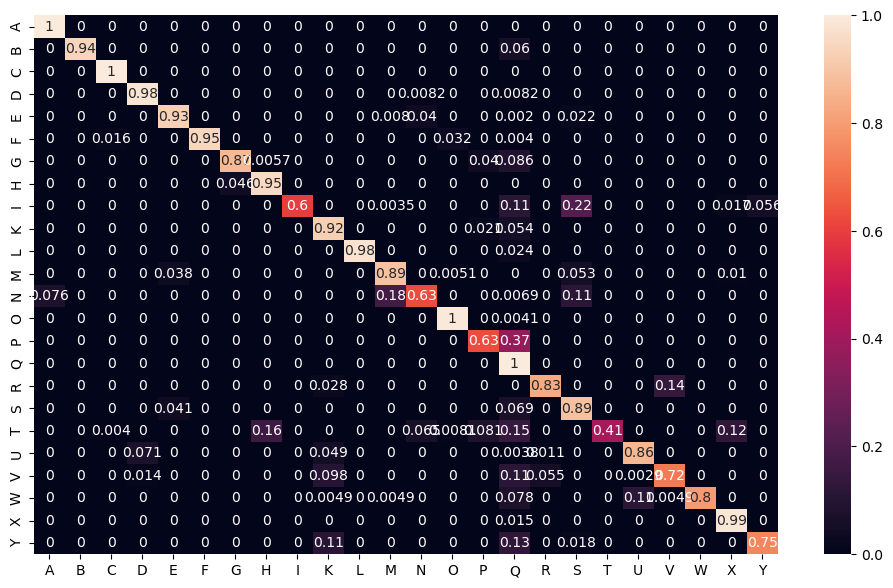

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Build confusion matrix
signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F',
         '6': 'G', '7': 'H', '8': 'I', '10': 'K', '11': 'L', '12': 'M',
         '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R', '18': 'S',
         '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }
lst = signs.values()
lst = list(lst)
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in lst],
                        columns=[i for i in lst])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)


In [ ]:
import numpy as np
import cv2
import torch

#from Model.network import Net

cap = cv2.VideoCapture(-1)

cap.set(3, 700)
cap.set(4, 480)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=Net()
model.to(device)
if torch.cuda.is_available():
    checkpoint = r"/home/cassanova/Documents/sign language classification/Pytorch-Sign-Language-Detection_CURRENT/weights/model_self.pt"
    checkpoints=torch.load(checkpoint)
    try:
        checkpoints.eval()
    except AttributeError as error:
        print(error)

    model.load_state_dict(checkpoints)
    model.eval()

signs = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I',
        '10': 'K', '11': 'L', '12': 'M', '13': 'N', '14': 'O', '15': 'P', '16': 'Q', '17': 'R',
        '18': 'S', '19': 'T', '20': 'U', '21': 'V', '22': 'W', '23': 'X', '24': 'Y' }

while True:
    ret, frame = cap.read()
    img = frame[100:250, 100:250]

    res = cv2.resize(img, dsize=(28, 28), interpolation = cv2.INTER_CUBIC)
    res = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)

    res1 = np.reshape(res, (1, 1, 28, 28)) / 255
    res2 = torch.from_numpy(res1)
    res3 = res2.type(torch.FloatTensor).cuda()

    out = model(res3)

    probs, label = torch.topk(out, 25)
    probs = torch.nn.functional.softmax(probs, 1)

    pred = out.max(1, keepdim=True)[1]

    if float(probs[0,0]) < 0.4:
        text = 'Sign not detected!'
    else:
        text = signs[str(int(pred))] + ': ' + '{:.2f}'.format(float(probs[0,0])) + '%'

    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(frame, text, (60,285), font, 1, (255,0,0), 2, cv2.LINE_AA)

    frame = cv2.rectangle(frame, (20, 20), (550, 250), (0, 255, 0), 3)

    cv2.imshow('Cam', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

'collections.OrderedDict' object has no attribute 'eval'


KeyboardInterrupt: 

: 